In [34]:
import matplotlib.pyplot as plt

def panel(ax_sx, hist, panel_title, trn_val, dev_val):
    ax_sx.set_title(panel_title)
    ax_sx.plot(hist.history[trn_val], color='#1f77b4')
    ax_sx.set_ylabel('train', color='#1f77b4')
    ax_sx.tick_params('y', colors='#1f77b4')
    ax_dx = ax_sx.twinx()
    ax_dx.plot(hist.history[dev_val], color='#ff7f0e')
    ax_dx.set_ylabel('validation', color='#ff7f0e')
    ax_dx.tick_params('y', colors='#ff7f0e')    

def show_training(history):
    fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    fig.suptitle('Training model', y=1.05)
    panel(ax11, history, 'accuracy', 'acc', 'val_acc')
    panel(ax12, history, 'loss', 'loss', 'val_loss')
    fig.tight_layout()
    plt.show()  


# Data

In [29]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import keras

# read in the training data
train_data = pd.read_csv('../data/sa_train.csv')
print(len(train_data), train_data['output'].unique())

train_texts = train_data['input']
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(train_texts)

# transform text into sequences of word IDs
X_train = t.texts_to_sequences(train_texts)
print(len(X_train))

# transform labels into numbers
labels2numbers = LabelEncoder()

# map labels to numbers
y_train_org = labels2numbers.fit_transform(train_data['output'])
print(y_train_org[:10], len(y_train_org))

# read in test data
test_data = pd.read_csv('../data/sa_test.csv')
print(len(test_data), test_data['output'].unique())

test_texts = test_data['input']

# transform test data into ID sequences
X_test = t.texts_to_sequences(test_texts)
print(len(X_test))

# transform test labels
y_test_org = labels2numbers.transform(test_data['output'])
print(y_test_org[:10], len(y_test_org))

# get number of classes for transformation
num_classes = max(y_train_org) + 1
# get vocabulary size
vocab_size = len(t.word_index) + 1 # vocabulary size (plus reserved index 0)

print('Convert class vector to binary 1-hot encoding matrix (for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train_org, num_classes)
y_test = keras.utils.to_categorical(y_test_org, num_classes)

1800 ['neg' 'pos']
1800
[0 0 0 1 1 0 1 1 0 0] 1800
200 ['pos' 'neg']
200
[1 0 0 0 1 0 0 1 0 0] 200
Convert class vector to binary 1-hot encoding matrix (for use with categorical_crossentropy)


# Version 1

In [30]:
# from keras examples
from keras.models import Sequential
from keras.layers import Embedding, Flatten
from keras.layers.core import Lambda, Dropout, Dense, Activation
from keras.layers.convolutional import Conv1D
from keras import backend as K

model = Sequential()
model.add(Embedding(output_dim=128, 
                    input_dim=vocab_size,
                    input_length=None))

# set parameters of matrices and convolution
nb_filter = 64
filter_length = 3
hidden_dims = 128

# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Conv1D(filters=nb_filter,  # Number of convolution kernels to use (dimensionality of the output).
                    kernel_size=filter_length, #  The extension (spatial or temporal) of each filter.
                    padding='valid',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=1))


# we use max over time pooling by defining a python function to use
# in a Lambda layer
def max_1d(X):
    return K.max(X, axis=1)
model.add(Lambda(max_1d, output_shape=(nb_filter,)))

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(rate=0.2))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         4857344   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 64)          24640     
_________________________________________________________________
lambda_3 (Lambda)            (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 258       
__________

In [32]:
k = sorted([len(xx) for xx in X_train])
f = k[int(len(k)/100*90)]

from keras.preprocessing.sequence import pad_sequences

maxlen = f

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [41]:
batch_size = 32
epochs = 5

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Train on 1620 samples, validate on 180 samples
Epoch 1/5
1620/1620 [==============================] - 13s 8ms/step - loss: 1.8201e-04 - acc: 1.0000 - val_loss: 1.0811e-04 - val_acc: 1.0000
Epoch 2/5
1620/1620 [==============================] - 11s 7ms/step - loss: 1.6042e-05 - acc: 1.0000 - val_loss: 6.0736e-05 - val_acc: 1.0000
Epoch 3/5
1620/1620 [==============================] - 10s 6ms/step - loss: 8.1189e-06 - acc: 1.0000 - val_loss: 4.3834e-05 - val_acc: 1.0000
Epoch 4/5
1620/1620 [==============================] - 10s 6ms/step - loss: 5.1601e-06 - acc: 1.0000 - val_loss: 3.4914e-05 - val_acc: 1.0000
Epoch 5/5
200/200 [==============================] - 0s 1ms/step
Test loss: 0.7849848714470863
Test accuracy: 0.81


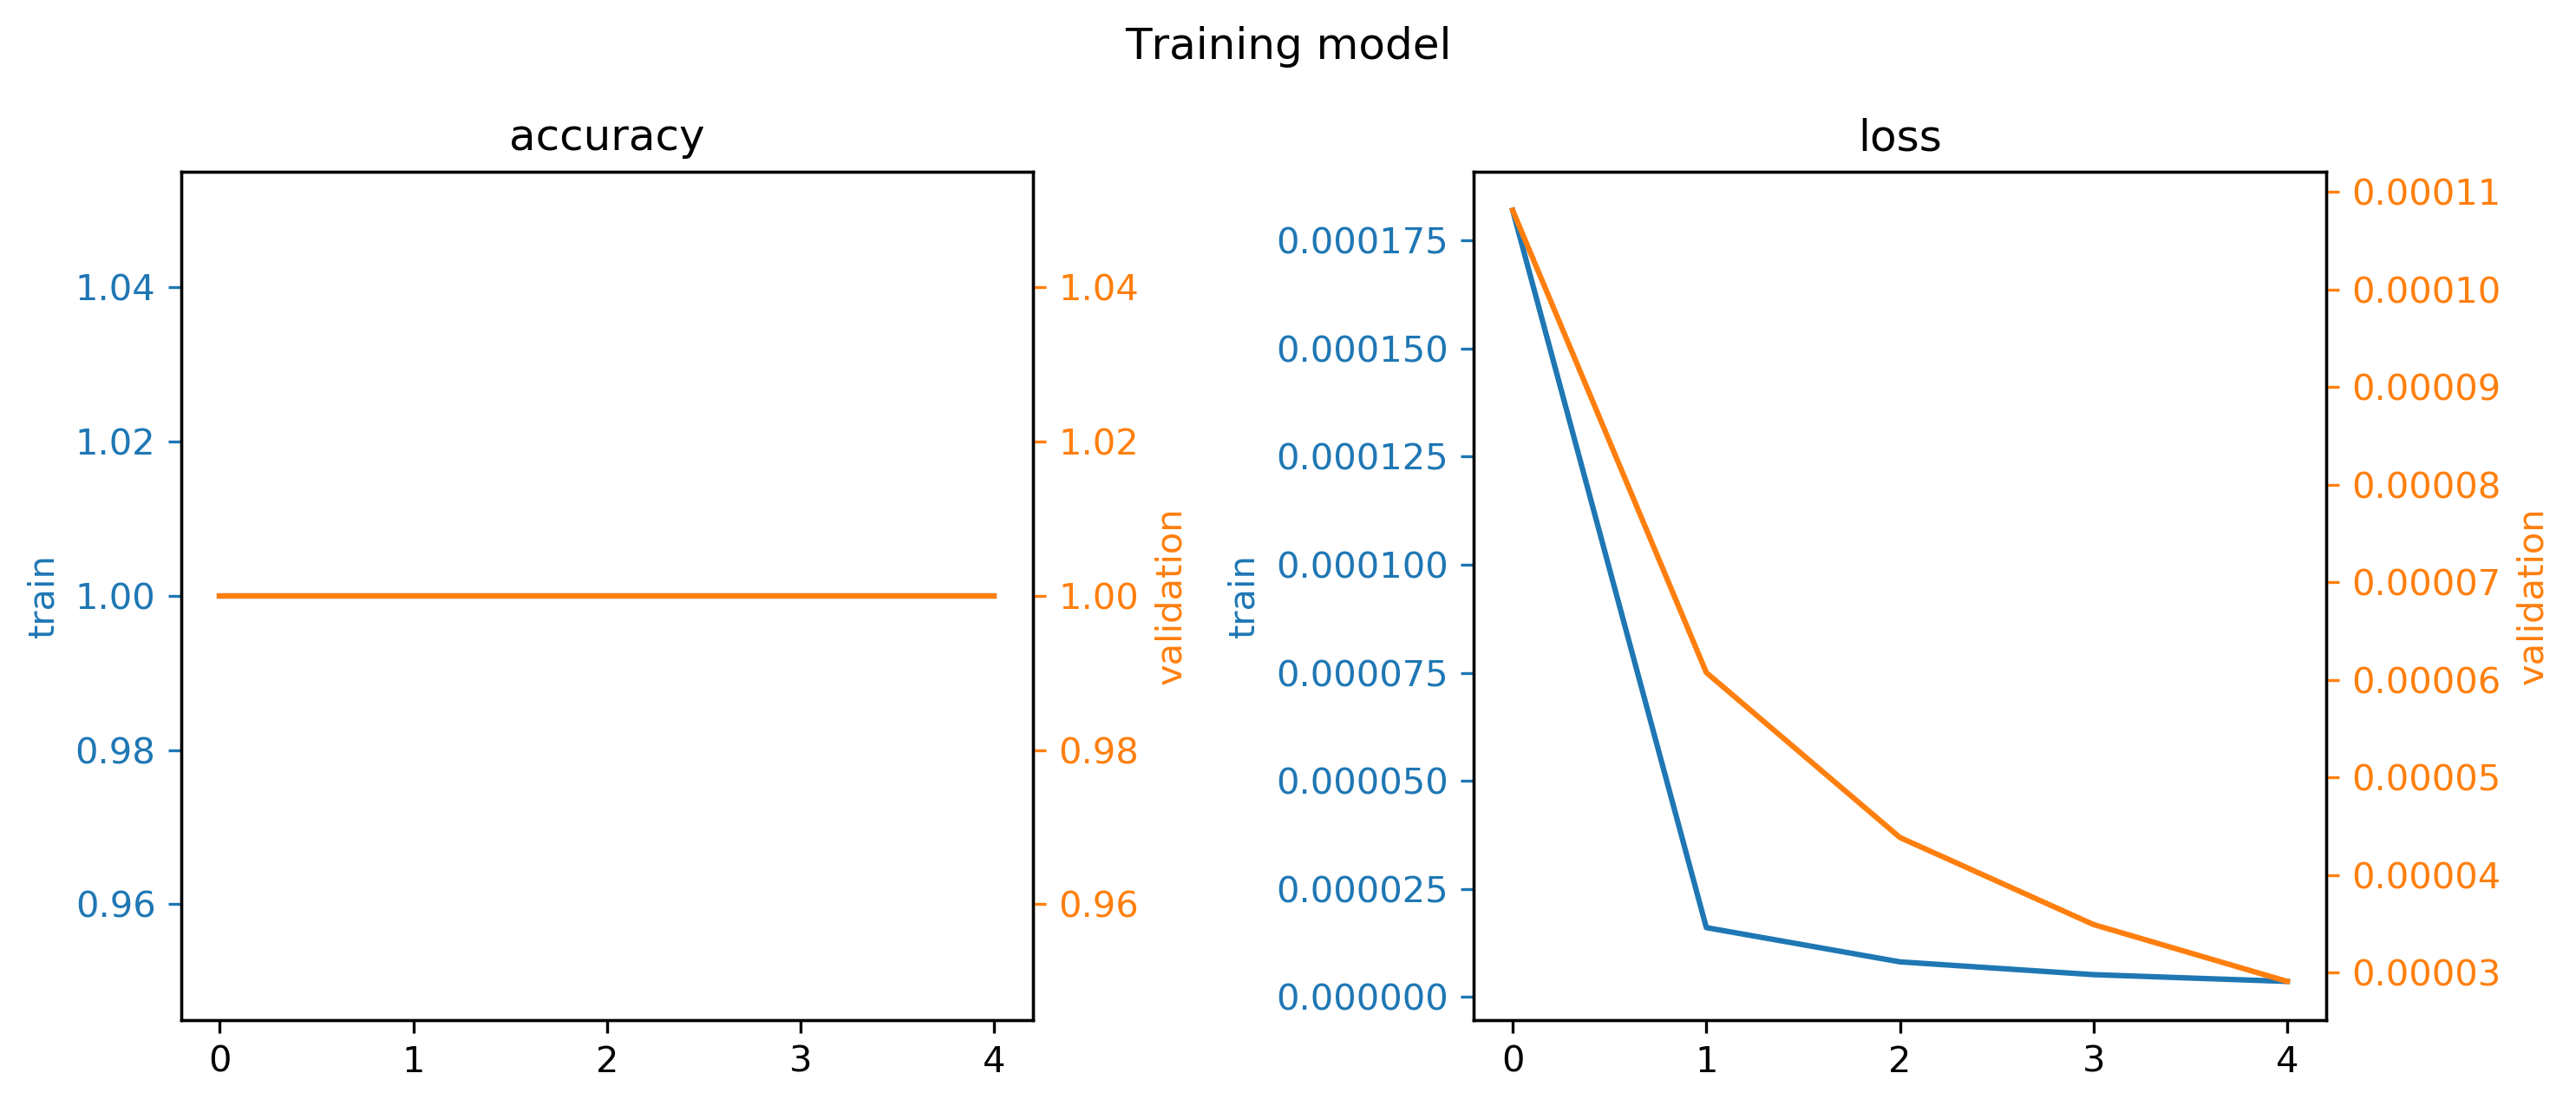

In [42]:
show_training(history)

# Version 2

In [43]:
from keras.layers import GlobalMaxPooling1D

embedding_dim = 50

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
# model.add(layers.Conv1D(hidden_dims, 5, activation='relu'))
model.add(Conv1D(filters=nb_filter,  # Number of convolution kernels to use (dimensionality of the output).
                    kernel_size=filter_length, #  The extension (spatial or temporal) of each filter.
                    padding='valid',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1056, 50)          1897400   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1054, 64)          9664      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 22        
Total params: 1,907,736
Trainable params: 1,907,736
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)

print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 1620 samples, validate on 180 samples
Epoch 1/5
1620/1620 [==============================] - 13s 8ms/step - loss: 0.6919 - acc: 0.5194 - val_loss: 0.6873 - val_acc: 0.5278
Epoch 2/5
1620/1620 [==============================] - 11s 7ms/step - loss: 0.6598 - acc: 0.7623 - val_loss: 0.6539 - val_acc: 0.6861
Epoch 3/5
1620/1620 [==============================] - 14s 8ms/step - loss: 0.5529 - acc: 0.8500 - val_loss: 0.5781 - val_acc: 0.7000
Epoch 4/5
1620/1620 [==============================] - 13s 8ms/step - loss: 0.3679 - acc: 0.9198 - val_loss: 0.5016 - val_acc: 0.7583
Epoch 5/5
1620/1620 [==============================] - 13s 8ms/step - loss: 0.1767 - acc: 0.9861 - val_loss: 0.4399 - val_acc: 0.7778
Training Accuracy: 0.9761
Testing Accuracy:  0.7650


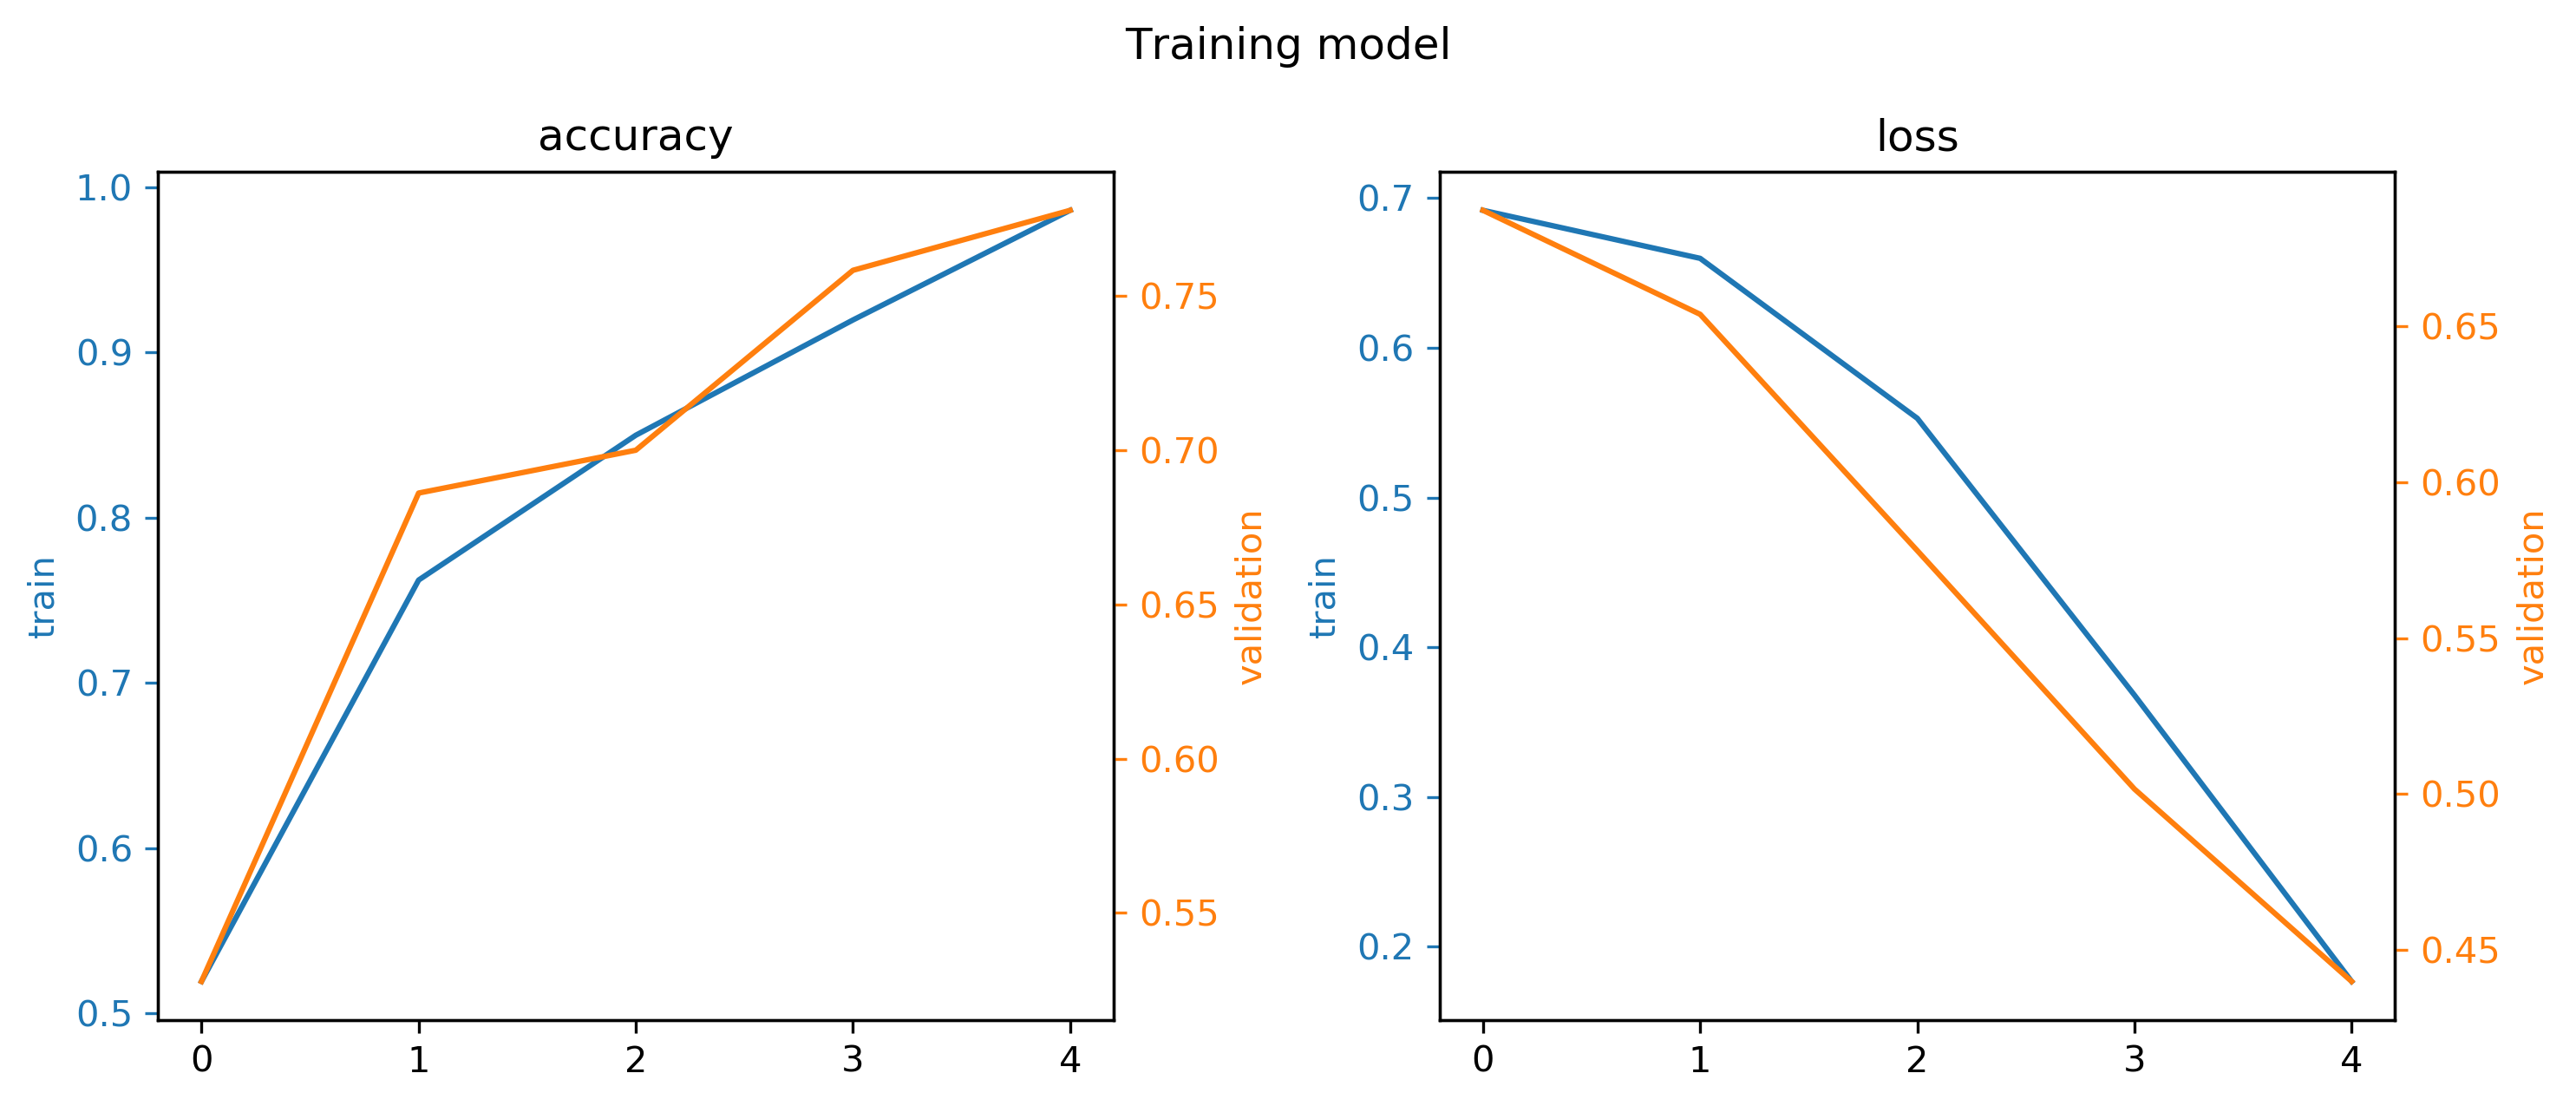

In [45]:
show_training(history)